## <font color='black'>Análise A/B Para Dados de uma Webpage </font>

O objetivo do projeto é determinar se há uma diferença estatisticamente significativa na taxa de cliques entre os grupos de controle e teste, ajudando a decidir se a diferença das webpages aumentam o engajamento dos usuários.

Link do dataset: https://www.kaggle.com/datasets/sergylog/ab-test-aggregated-data

In [1]:
# Imports
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
random.seed(42)

### <font color='black'>Carregando os Dados.</font>

In [2]:
# Carregar df
df = pd.read_csv('ab_test.csv')

In [3]:
# Primeiros valores do df
df.head()

,user_id,group,views,clicks
0,1,control,10.0,0.0
1,2,control,1.0,0.0
2,3,control,1.0,0.0
3,4,control,2.0,0.0
4,5,control,3.0,0.0


In [4]:
# Shape
df.shape

(120000, 4)

### <font color='black'>Análise Exploratória</font>

In [5]:
# Verifica se há valores nulos
print(df.isnull().sum())

user_id    0
group      0
views      0
clicks     0
dtype: int64


In [6]:
# Verifica a distribuição dos grupos (controle e teste)
print(df['group'].value_counts())

group
control    60000
test       60000
Name: count, dtype: int64


In [7]:
# Visualizações por grupo
views_per_group = df.groupby('group')['views'].sum().reset_index()

# Clicks por grupo
clicks_per_group = df.groupby('group')['clicks'].sum().reset_index()

# Juntando as informações em uma única tabela usando merge
tabela_final = pd.merge(clicks_per_group, views_per_group, on='group')
tabela_final.columns = ['Grupos', 'Total de Clicks', 'Total de Views']  # Renomeando as colunas

tabela_final

,Grupos,Total de Clicks,Total de Views
0,control,10303.0,297144.0
1,test,11620.0,301785.0


In [8]:
# Calculando a relação de clicks por view de cada grupo
tabela_final['Clicks/Views'] = tabela_final['Total de Clicks'] / tabela_final['Total de Views']
tabela_final['Clicks/Views'] = tabela_final['Clicks/Views'].apply(lambda x: f'{x:.2%}')
tabela_final

,Grupos,Total de Clicks,Total de Views,Clicks/Views
0,control,10303.0,297144.0,3.47%
1,test,11620.0,301785.0,3.85%


In [9]:
# Reorganizando o DataFrame para o formato desejado
df_final = pd.melt(tabela_final, 
                              id_vars='Grupos', 
                              value_vars=['Total de Clicks', 'Total de Views'], 
                              var_name='Métrica', 
                              value_name='Valor')

In [10]:
df_final

,Grupos,Métrica,Valor
0,control,Total de Clicks,10303.0
1,test,Total de Clicks,11620.0
2,control,Total de Views,297144.0
3,test,Total de Views,301785.0


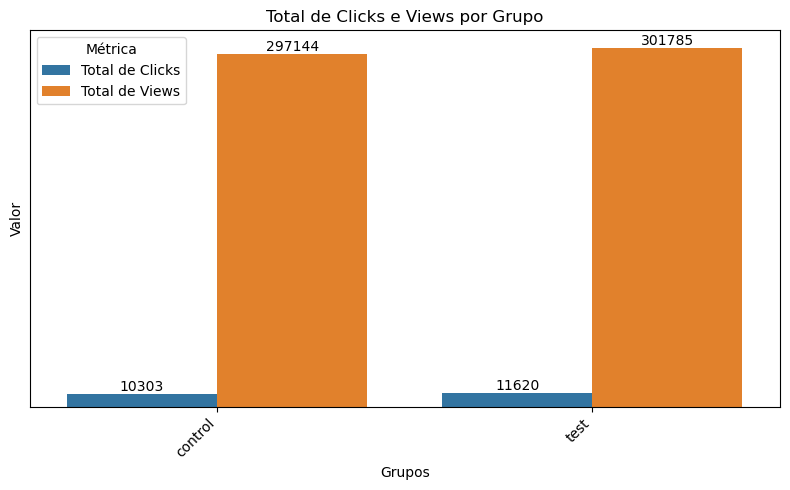

In [11]:
# Criando o gráfico de barras
plt.figure(figsize=(8, 5))
ax = sns.barplot(x='Grupos', y='Valor', hue='Métrica', data=df_final)
plt.title('Total de Clicks e Views por Grupo')
plt.xlabel('Grupos')
plt.yticks([]) 
plt.xticks(rotation=45, ha='right')

# Adicionando os valores acima das barras
for i in ax.containers:
    ax.bar_label(i)

plt.tight_layout()
plt.show()

Agora que os dados foram explorados, será removida a variável views do dataset, visto que os testes serão aplicados somente a variável clicks

In [12]:
df.drop(columns = ["views", 'user_id'], inplace = True)

In [13]:
df.head()

,group,clicks
0,control,0.0
1,control,0.0
2,control,0.0
3,control,0.0
4,control,0.0


### <font color='black'>Analisando Teste Teste t de Student Para Amostras Independentes</font>

O Teste t de Student para duas amostras independentes verifica se há uma diferença estatisticamente significativa entre as médias de dois grupos. Ele exige que os grupos sejam independentes, que os dados sejam aproximadamente normais (especialmente para tamanhos de amostra menores) e que as variâncias dos grupos sejam iguais (caso contrário, use alternativas como o teste de Welch). A hipótese nula é que as médias dos grupos são iguais, enquanto a hipótese alternativa sugere que são diferentes.

In [14]:
df.sample(5)

,group,clicks
76224,test,0.0
21032,control,0.0
26284,control,0.0
115727,test,1.0
114046,test,0.0


In [15]:
# Separa os grupos de controle e tratamento
grupo_controle = df[df['group'] == 'control']
grupo_tratamento = df[df['group'] == 'test']

In [16]:
# Calcule a média das views
taxa_controle = grupo_controle['clicks'].mean()
taxa_tratamento = grupo_tratamento['clicks'].mean()

In [17]:
print(f"Média views grupo controle: {taxa_controle}")
print(f"Média views grupo tratamento: {taxa_tratamento}")

Média views grupo controle: 0.17171666666666666
Média views grupo tratamento: 0.19366666666666665


In [18]:
# Teste de hipóteses
alfa = 0.05
hipotese_nula = "Não há diferença na taxa de clicks entre o grupo de controle e grupo de tratamento"
hipotese_alternativa = "Há diferença na taxa de clicks entre o grupo de controle e grupo de tratamento"

In [19]:
# Aplica o teste
estatistica_t, p_valor = stats.ttest_ind(grupo_controle['clicks'], grupo_tratamento['clicks'])

In [20]:
print(f"Estatística t: {estatistica_t}")
print(f"Valor-p: {p_valor}")

Estatística t: -8.04758450992411
Valor-p: 8.520775106071576e-16


A função stats.ttest_ind() é uma função da biblioteca SciPy. Esta função realiza um Teste t de Student independente para duas amostras. O objetivo do Teste t é determinar se existe uma diferença estatisticamente significativa entre as médias de duas populações independentes.

A função stats.ttest_ind() recebe dois argumentos principais, que são as duas amostras (geralmente na forma de listas, arrays ou séries do pandas) para as quais você deseja testar a diferença entre as médias. A função retorna dois valores: a estatística t e o valor p.

A estatística t é um valor calculado que ajuda a determinar a diferença entre as médias das duas amostras em relação ao erro padrão combinado das amostras. Um valor t grande (positivo ou negativo) indica uma diferença maior entre as médias, enquanto um valor t próximo de zero indica que as médias são semelhantes.

O valor-p é uma medida de significância estatística. Ele indica a probabilidade de observar uma diferença igual ou maior do que a encontrada, assumindo que não há diferença real entre as médias das populações (ou seja, a hipótese nula é verdadeira). Um valor-p baixo (geralmente menor que 0,05) sugere que podemos rejeitar a hipótese nula e concluir que há uma diferença estatisticamente significativa entre as médias das duas populações.

In [21]:
# Resultado
if p_valor < alfa:
    print(f"Rejeitamos a hipótese nula.\n{hipotese_alternativa}")
else:
    print(f"Falhamos em rejeitar a hipótese nula.\n{hipotese_nula}")

Rejeitamos a hipótese nula.
Há diferença na taxa de clicks entre o grupo de controle e grupo de tratamento


### <font color='black'>Testando a Normalidade das Amostras</font>

### <font color='black'>Teste Shapiro-Wilk</font>

O teste Shapiro-Wilk é um método estatístico que verifica se um conjunto de dados veio de uma distribuição normal. Em outras palavras, ele avalia se os dados se parecem com uma curva em forma de sino.

Como interpretar o resultado:

O teste gera um valor chamado de "valor-p".

Valor-p alto (geralmente acima de 0,05): Sugere que os dados são consistentes com uma distribuição normal.<br>
Valor-p baixo (geralmente igual ou menor que 0,05): Indica que os dados provavelmente não vêm de uma distribuição normal.



In [22]:
# Import
from scipy.stats import shapiro

In [23]:
# Teste de Shapiro-Wilk para verificar a normalidade
stat_A, p_A = shapiro(grupo_controle['clicks'])
stat_B, p_B = shapiro(grupo_tratamento['clicks'])

In [24]:
print(f"Resultado do teste de Shapiro-Wilk para o Grupo de Controle: Estatística={stat_A:.3f}, Valor-p={p_A:.3f}")
print(f"Resultado do teste de Shapiro-Wilk para o Grupo de Tratamento: Estatística={stat_B:.3f}, Valor-p={p_B:.3f}")

Resultado do teste de Shapiro-Wilk para o Grupo de Controle: Estatística=0.419, Valor-p=0.000
Resultado do teste de Shapiro-Wilk para o Grupo de Tratamento: Estatística=0.439, Valor-p=0.000


In [25]:
# Interpretando os resultados

nivel_significancia = 0.05

if p_A > nivel_significancia:
    print("Não há evidências suficientes para rejeitar a hipótese de normalidade para o Grupo de Controle.")
else:
    print("Há evidências suficientes para rejeitar a hipótese de normalidade para o Grupo de Controle.")

if p_B > nivel_significancia:
    print("Não há evidências suficientes para rejeitar a hipótese de normalidade para o Grupo de Tratamento.")
else:
    print("Há evidências suficientes para rejeitar a hipótese de normalidade para o Grupo de Tratamento.")

Há evidências suficientes para rejeitar a hipótese de normalidade para o Grupo de Controle.
Há evidências suficientes para rejeitar a hipótese de normalidade para o Grupo de Tratamento.


Os dados não passaram na validação de uma das suposições do teste t. Logo, não poderemos usar as conclusões do teste t. Vamos aplicar uma alternativa não paramétrica.

### <font color='black'>Teste de Mann-Whitney U</font>

O Teste de Mann-Whitney U é um teste estatístico não paramétrico utilizado para comparar as medianas de duas amostras independentes. É especialmente útil quando as premissas de normalidade dos dados não são atendidas, o que é comum em muitas situações práticas. O teste é uma alternativa ao teste t de Student para amostras independentes quando os dados não são normalmente distribuídos.

O Teste de Mann-Whitney U é adequado para testar a hipótese de que duas amostras provêm de distribuições com a mesma mediana. Ele é particularmente útil em estudos médicos, pesquisas sociais e outros campos onde as premissas de normalidade muitas vezes falham. Se o valor-p é pequeno (geralmente abaixo de 0,05), rejeita-se a hipótese nula, sugerindo uma diferença estatisticamente significativa entre as medianas dos grupos.

In [26]:
# Teste de hipóteses
alfa = 0.05
hipotese_nula = "Não há diferença significativa na mediana entre o grupo de controle e o grupo de tratamento."
hipotese_alternativa = "Há diferença significativa na mediana entre o grupo de controle e o grupo de tratamento."

In [27]:
# Import
from scipy.stats import mannwhitneyu

In [28]:
# Aplica o teste de Mann-Whitney
estatistica_u, valor_p = mannwhitneyu(grupo_controle['clicks'], 
                                      grupo_tratamento['clicks'], 
                                      alternative = 'two-sided')

In [29]:
print(f"Estatística t: {estatistica_u}")
print(f"Valor-p: {valor_p}")

Estatística t: 1772621998.0
Valor-p: 3.362997071095112e-13


In [30]:
# Resultado
if p_valor < alfa:
    print(f"Rejeitamos a hipótese nula.\n{hipotese_alternativa}")
else:
    print(f"Falhamos em rejeitar a hipótese nula.\n{hipotese_nula}")

Rejeitamos a hipótese nula.
Há diferença significativa na mediana entre o grupo de controle e o grupo de tratamento.


### <font color='black'>Conclusão</font>
Os resultados do teste Mann-Whitney U indicam uma diferença significativa na mediana de cliques entre o grupo de controle e o grupo de tratamento. O valor-p extremamente baixo demonstra que essa diferença dificilmente ocorreria por acaso, reforçando a eficácia da campanha de marketing.

### <font color='black'>Sistema e Versões dos Pacotes</font>

In [31]:
%reload_ext watermark
%watermark -v -m
%watermark --iversions

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.25.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 126 Stepping 5, GenuineIntel
CPU cores   : 4
Architecture: 64bit

matplotlib : 3.8.4
numpy      : 1.26.4
seaborn    : 0.13.2
statsmodels: 0.14.2
scipy      : 1.13.1
pandas     : 2.2.2

